Extinction: Eclipse Depth Difference as Function of Temperature
============================

In this example, we'll reproduce Figure 3 in the extinction release paper ([Jones et al. 2020](http://phoebe-project.org/publications/2020Jones+)).

**NOTE**: this script takes a long time to run.

<img src="jones+20_fig3.png" alt="Figure 3" width="800px"/>

Setup
-----------------------------


Let's first make sure we have the latest version of PHOEBE 2.3 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.3,<2.4"

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.ipynb) for more details.

In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib import gridspec

In [2]:
%matplotlib inline

In [3]:
from astropy.table import Table

In [4]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger('error')

b = phoebe.default_binary()

First we'll define the system parameters

In [5]:
b['period@orbit']=10*u.d
b['teff@secondary']=5780.*u.K
b['requiv@secondary']=1.0*u.solRad
b.flip_constraint('mass@primary', solve_for='sma@binary')
b.flip_constraint('mass@secondary', solve_for='q')

<ConstraintParameter: {q@binary@component} = {mass@secondary@component} / {mass@primary@component} (solar units) => 1.0>

And then create three light curve datasets at the same times, but in different passbands

In [6]:
times = phoebe.linspace(0, 10, 301)
b.add_dataset('lc', times=times, dataset='B', passband="Johnson:B")
b.add_dataset('lc', times=times, dataset='R', passband="Cousins:R")

<ParameterSet: 43 parameters | contexts: constraint, figure, compute, dataset>

Now we'll set some atmosphere and limb-darkening options

In [7]:
b.set_value_all('gravb_bol', 0.0)
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.0])

And flip the extinction constraint so we can provide E(B-V).

In [9]:
b.flip_constraint('ebv', solve_for='Av')

In [10]:
masses=np.array([ 0.6 ,  0.7 ,  0.8 ,  0.9 ,  1.  ,  1.1 ,  1.2 ,  1.3 ,  1.4 ,
        1.5 ,  1.6 ,  1.7 ,  1.8 ,  1.9 ,  1.95,  2.  ,  2.1 ,  2.2 ,
        2.3 ,  2.5 ,  3.  ,  3.5 ,  4.  ,  4.5 ,  5.  ,  6.  ,  7.  ,
        8.  , 10.  , 12.  , 15.  , 20.  ])
temps=np.array([ 4285.,  4471.,  4828.,  5242.,
        5616.,  5942.,  6237.,  6508.,
        6796.,  7121.,  7543.,  7968.,
        8377.,  8759.,  8947.,  9130.,
        9538.,  9883., 10155., 10801.,
       12251., 13598., 14852., 16151.,
       17092., 19199., 21013., 22526.,
       25438., 27861., 30860., 34753.])
radii=np.array([0.51, 0.63, 0.72, 0.80, 0.90,
       1.01, 1.13, 1.26, 1.36, 1.44,
       1.48, 1.51, 1.54, 1.57, 1.59,
       1.61, 1.65, 1.69, 1.71, 1.79,
       1.97, 2.14, 2.30, 2.48, 2.59,
       2.90, 3.17, 3.39, 3.87, 4.29,
       4.85, 5.69])

t=Table(names=('Mass','Tdiff','B1','B2','R1','R2'), dtype=('f4', 'f4', 'f8', 'f8', 'f8', 'f8'))

In [11]:
def binmodel(teff,requiv,mass):
    b.set_value('teff', component='primary', value=teff*u.K)
    b.set_value('requiv', component='primary', value=requiv*u.solRad)
    b.set_value('mass', component='primary', value=mass*u.solMass)
    b.set_value('mass', component='secondary', value=1.0*u.solMass)
    
    b.set_value('ebv', value=0.0)
    b.run_compute(distortion_method='rotstar', irrad_method='none', model='noext', overwrite=True)
    
    b.set_value('ebv', value=1.0)
    b.run_compute(distortion_method='rotstar', irrad_method='none', model='ext', overwrite=True)
    
    Bextmags=-2.5*np.log10(b['value@fluxes@B@ext@model'])
    Bnoextmags=-2.5*np.log10(b['value@fluxes@B@noext@model'])
    Bdiff=(Bextmags-Bextmags.min())-(Bnoextmags-Bnoextmags.min())
    Rextmags=-2.5*np.log10(b['value@fluxes@R@ext@model'])
    Rnoextmags=-2.5*np.log10(b['value@fluxes@R@noext@model'])
    Rdiff=(Rextmags-Rextmags.min())-(Rnoextmags-Rnoextmags.min())
    tdiff=teff-5780
    t.add_row((mass, tdiff, Bdiff[0],Bdiff[150],Rdiff[0],Rdiff[150]))

In [12]:
def binmodel_teff(teff):
    b.set_value('teff', component='primary', value=teff*u.K)
    
    b.set_value('ebv', value=0.0)
    b.run_compute(distortion_method='rotstar', irrad_method='none', model='noext', overwrite=True)
    
    b.set_value('ebv', value=1.0)
    b.run_compute(distortion_method='rotstar', irrad_method='none', model='ext', overwrite=True)
    
    Bextmags=-2.5*np.log10(b['value@fluxes@B@ext@model'])
    Bnoextmags=-2.5*np.log10(b['value@fluxes@B@noext@model'])
    Bdiff=(Bextmags-Bextmags.min())-(Bnoextmags-Bnoextmags.min())
    Rextmags=-2.5*np.log10(b['value@fluxes@R@ext@model'])
    Rnoextmags=-2.5*np.log10(b['value@fluxes@R@noext@model'])
    Rdiff=(Rextmags-Rextmags.min())-(Rnoextmags-Rnoextmags.min())
    tdiff=teff-5780
    t_teff.add_row((tdiff, Bdiff[0],Bdiff[150],Rdiff[0],Rdiff[150]))

In [13]:
# NOTE: this loop takes a long time to run
for i in range(0,len(masses)):
    binmodel(temps[i], radii[i], masses[i])
    
#t.write("Extinction_G2V_ZAMS.dat", format='ascii', overwrite=True)

(-1450, 25000)

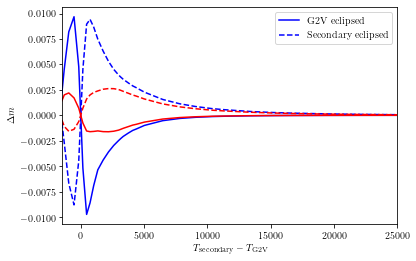

In [15]:
#t=Table.read("Extinction_G2V_ZAMS.dat", format='ascii')

plt.clf()
plt.plot(t['Tdiff'],t['B1'],color="b",ls="-", label="G2V eclipsed")
plt.plot(t['Tdiff'],t['B2'],color="b",ls="--", label="Secondary eclipsed")

plt.plot(t['Tdiff'],t['R1'],color="r",ls="-", label="")
plt.plot(t['Tdiff'],t['R2'],color="r",ls="--", label="")

plt.ylabel(r'$\Delta m$ ')
plt.xlabel(r'$T_\mathrm{secondary} - T_\mathrm{G2V}$')
plt.legend()
plt.xlim([-1450,25000])

In [14]:
t_teff=Table(names=('Tdiff','B1','B2','R1','R2'), dtype=('f4', 'f8', 'f8', 'f8', 'f8'))
b.set_value('requiv', component='primary', value=1.0*u.solRad)
b.set_value('mass', component='primary', value=1.0*u.solMass)
b.set_value('mass', component='secondary', value=1.0*u.solMass)

# NOTE: this loop takes a long time to run
for i in range(0,len(temps)):
    binmodel_teff(temps[i])
    
#t_teff.write("Extinction_Solar_exceptTeff_test.dat", format='ascii', overwrite=True)

(-1450, 25000)

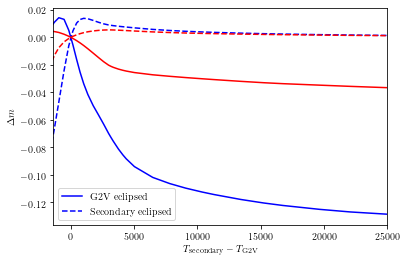

In [16]:
#t_teff=Table.read("Extinction_Solar_exceptTeff_test.dat", format='ascii')

plt.clf()
plt.plot(t_teff['Tdiff'],t_teff['B1'],color="b",ls="-", label="G2V eclipsed")
plt.plot(t_teff['Tdiff'],t_teff['B2'],color="b",ls="--", label="Secondary eclipsed")

plt.plot(t_teff['Tdiff'],t_teff['R1'],color="r",ls="-", label="")
plt.plot(t_teff['Tdiff'],t_teff['R2'],color="r",ls="--", label="")

plt.ylabel(r'$\Delta m$ ')
plt.xlabel(r'$T_\mathrm{secondary} - T_\mathrm{G2V}$')
plt.legend()
plt.xlim([-1450,25000])